# Comparator Optiimization


In [11]:
import pyzx as zx


## Using ZX

First, we take the initial circuit that straightforwardly transformed from the classical logic circuit, and optimize it using ZX calculus. 

---

In [12]:
initial_circuit: str = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
h q[0];
h q[1];
cx q[0], q[3];
cx q[1], q[3];
x   q[3];
x   q[0];
ccx q[0], q[1], q[2];
x   q[0];
x   q[1];
ccx q[0], q[1], q[4];
x   q[1];
"""

circ = zx.Circuit.from_qasm(initial_circuit).to_basic_gates()
print(circ.stats())

Circuit  on 5 qubits with 39 gates.
        14 is the T-count
        25 Cliffords among which
        14 2-qubit gates (14 CNOT, 0 other) and
        6 Hadamard gates.


We can improve the T count using `full reduce`. To do so, we need to first convert the circuit to a ZX diagram, after extract the optimized circuit from the diagram after the reduction.

---

In [13]:
graph = zx.Circuit.to_graph(circ)
zx.full_reduce(graph)
cirt_opt = zx.extract_circuit(graph)
print(cirt_opt.stats())

Circuit  on 5 qubits with 50 gates.
        8 is the T-count
        42 Cliffords among which
        19 2-qubit gates (2 CNOT, 17 other) and
        20 Hadamard gates.


### Exploiting Logic Optimization

An alternative way is to generate the circuit smarter, by oberserving that the second Toffoli is unnecessary and can be replaced by 3 CNOTs, and we can directly generate the circuit with only one Toffoli gate.

---

In [14]:
cnot_optimized_circuit: str = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
h q[0];
h q[1];
cx q[0], q[3];
cx q[1], q[3];
x   q[3];
x   q[0];
ccx q[0], q[1], q[2];
x   q[0];
x   q[1];
cx  q[0], q[4];
cx  q[1], q[4];
cx  q[2], q[4];
x   q[1];
"""

In [15]:
circ = zx.Circuit.from_qasm(cnot_optimized_circuit).to_basic_gates()
print(circ.stats())

Circuit  on 5 qubits with 27 gates.
        7 is the T-count
        20 Cliffords among which
        11 2-qubit gates (11 CNOT, 0 other) and
        4 Hadamard gates.


In [16]:
graph = zx.Circuit.to_graph(circ)
zx.full_reduce(graph)
cirt_opt = zx.extract_circuit(graph)
print(cirt_opt.stats())

Circuit  on 5 qubits with 43 gates.
        7 is the T-count
        36 Cliffords among which
        16 2-qubit gates (1 CNOT, 15 other) and
        18 Hadamard gates.


### Summary

In this case, PyZX cannot further optimize the circuit. It does not reduce the T count after `full reduce` and even increases the CNOT count. 

---

## Using Phase Polynomial and Our Optimizer

In [17]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent / 'src'))
from circuitExtract import extract_q_opt
from logicNetwork import LogicNetwork
from quantumCircuit import QuantumCircuit
from visualization import plot_circuit

verilog_str = """
module top (  a, b  );
    input  a, b;
    output lt, eq, gt;

    assign lt = a & ~b;
    assign eq = ~a ^ ~b;
    assign gt = ~a & b;

endmodule
"""

network = LogicNetwork.from_verilog(verilog_str)
circuit: QuantumCircuit = extract_q_opt(network, run_zx=False)
print({"n_ands": network.n_ands, "n_t": circuit.num_t, "n_qubits": circuit.n_qubits, "n_2q": circuit.num_2q})

{'n_ands': 2, 'n_t': 8, 'n_qubits': 5, 'n_2q': 14}


<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/quantum/lib/python3.13/site-packages/matplotlib/pyplot.py'>

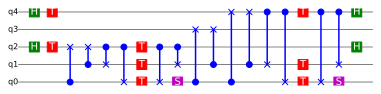

In [18]:
plot_circuit(circuit)

### A 4-T Circuit

We can do better and further reduce the T count to 4.

In [19]:
t_optimal_qasm_str = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
h q[0];
h q[1];
cx q[0], q[3];
cx q[1], q[3];
x   q[3];
x   q[0];
h   q[2];
t   q[2];
cx q[0], q[2];
cx q[1], q[2];
cx q[2], q[0];
cx q[2], q[1];
tdg q[0];
tdg q[1];
t   q[2];
cx q[2], q[0];
cx q[2], q[1];
h   q[2];
s   q[0];
ccx q[0], q[1], q[2];
x   q[0];
x   q[1];
cx  q[0], q[4];
cx  q[1], q[4];
cx  q[2], q[4];
x   q[1];
"""

t_opt_circuit: QuantumCircuit = QuantumCircuit.from_qasm(t_optimal_qasm_str)
print({"n_ands": network.n_ands, "n_t": t_opt_circuit.num_t, "n_qubits": t_opt_circuit.n_qubits, "n_2q": t_opt_circuit.num_2q})

{'n_ands': 2, 'n_t': 4, 'n_qubits': 5, 'n_2q': 11}


<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/quantum/lib/python3.13/site-packages/matplotlib/pyplot.py'>

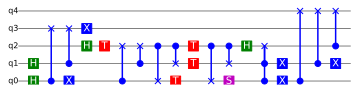

In [10]:
plot_circuit(t_opt_circuit)